In [1]:
# Import own modules
# SelfSupervised
import modules.selfsupervised.simclr_model as sm 
import modules.selfsupervised.simclr_train as smtr
# Evaluation
import modules.evaluation.lin_eval_testmoduls as let
# Utils
import modules.utils.transformations as t 
import modules.utils.loss_functions as lf
import modules.utils.lars as lars
# Settings
import modules.utils.get_data as get 
# Reporting 
import modules.utils.reporting as report 
# Saving Model
import modules.utils.save_model as savem
# Get Model
import modules.utils.get_model as gm 
# Import extern modules
import argparse
import torchvision
import torch 
import torch.nn as nn
from torch.nn.parallel import DataParallel
import math 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Create an Argparser
parser = argparse.ArgumentParser(description='Train simCLRv1 on CIFAR-10')
# Model-Architecture
parser.add_argument('-a', '--arch', default='resnet18')
# lr: 0.06 for batch 512 (or 0.03 for batch 256) 0.12 for 1024?
parser.add_argument('--lr', '--learning-rate', default=1e-3, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--epochs', default=20, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('--schedule', default=[1020, 1060], nargs='*', type=int, help='learning rate schedule (when to drop lr by 10x); does not take effect if --cos is on')
parser.add_argument('--cos', default="False", type=str, help='use cosine lr schedule')
parser.add_argument('--squared', default="False", type=str, help='use square lr schedule')
parser.add_argument('--batch-size', default=768, type=int, metavar='N', help='mini-batch size')
parser.add_argument('--wd', default=1e-6, type=float, metavar='W', help='weight decay')
parser.add_argument('--dataset', default="IMAGENET", type=str, metavar='W', help='dataset')
parser.add_argument('--dataset-dir', default="data/imagenet128", type=str, metavar='W', help='dataset directory')
parser.add_argument('--optimizer', default="adam", type=str, metavar='W', help='Adam, SGD, Lars')
# SIMCLR specific configs:
parser.add_argument('--dim', default=128, type=int, help='feature dimension')
parser.add_argument('--t', default=0.1, type=float, help='softmax temperature')
parser.add_argument('--numberviews', default=2, type=int, help='Number of Views created for Avg.Loss')
# Training/Test Settings
parser.add_argument('--model-dir', default="", type=str, metavar='W', help='if test true give model dir!')
parser.add_argument('--model-name', default="", type=str, metavar='W', help='if test true give model dir!')
# Linear Evaluation
parser.add_argument('--epochs-lineval', default=100, type=int, metavar='N', help='number of total epochs to run in linEval')
# Labels
parser.add_argument('--labels', default="full", type=str, metavar='N', help='1%, 10% or full labelled data sets are supported')
# Multiple GPUs
parser.add_argument('--dataparallel', default="True", type=str, metavar='W', help='multiple gpus true or false')
# Reload
parser.add_argument('--reload', default="False", type=str, metavar='W', help='reload true or false')
# Verbose
parser.add_argument('--verbose', default="True", type=str, help='True if you want to evaluate your representations after each epoch (obviously SLOWER!)')

# Set up args
args = parser.parse_args("")

# Convert 
args.dataparallel = True if str.lower(args.dataparallel) == "true" else False
args.reload = True if str.lower(args.reload) == 'true' else False
args.verbose = True if str.lower(args.verbose) == 'true' else False
args.cos = True if str.lower(args.cos) == 'true' else False
args.squared = True if str.lower(args.squared) == 'true' else False
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
args.num_gpus = torch.cuda.device_count()

In [3]:
args.dataset = "IMAGENET"
args.dataset_dir = "data/imagenet128"
args.labels = "10%"
args.batch_size = 768

In [9]:
def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        ####################
        ## YOUR CODE HERE ##
        ####################
        extra_point=plt.plot(extra_pt[0],extra_pt[1],'k.',label=extra_pt_label, markersize=16)
        if extra_pt_label:
            legend.append(extra_pt_label)

        # END OF YOUR CODE #
        
    plt.vlines(20, 0, 1)
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

In [5]:
# Set Reporting up
#writer_train, writer_val, mkdirpath = report.setReportingUp_trainingSimclr(args)
# Get Data
train_loader, train_loader_nonaug, val_loader = get.data_trainingSimclr(args)
# Get encoder
encoder = get.encoder(args)
args.featureDim, args.numberClasses, epoch_start = encoder.fc.in_features, get.numberClasses(args), 1
# Choose Model
model = sm.modelSIMCLR(encoder, args.featureDim, lf.contrastive_loss_cosine_extra, dim=args.dim, T=args.t)
# Get Optimizer
optimizer = get.optimizer_training(model, args)
# Check Reload
checkpoint = torch.load("saved_models/selfsupervised/imagenet/100ep_256_r18_224_augs/checkpoint_100.tar", map_location=args.device.type)
model = model.cuda()
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_start = checkpoint['epoch']+1
    
criterion = nn.CrossEntropyLoss()

In [6]:
#optimizer = get.optimizer_training(model, args)

In [7]:
trainedEncoder = model.encoder_f
trainedEncoder.fc = torch.nn.Linear(512,1000)
model = trainedEncoder.cuda()

In [8]:
# Start training
train_losses =[]
val_losses = []
train_accs = []
val_accs = []

"""
for epoch in range(epoch_start, args.epochs + 1):
    train_loss, neg_sim, pos_sim, lr = smtr.train(model, train_loader, optimizer, epoch, args)
    if (epoch % 1) == 0:
        model.module.switch = True
        for _ in range(1):
            train_loss, train_acc = let.train_lr(train_loader_nonaug, model, criterion, optimizer, epoch, args.epochs, args)
            val_loss, val_acc = let.test_lr(val_loader, model, criterion, epoch, args.epochs, args)
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
        model.module.switch = False
"""       
model.switch = True
for epoch in range(50):
    train_loss, train_acc = let.train_lr(train_loader_nonaug, model, criterion, optimizer, epoch, args.epochs, args)
    val_loss, val_acc = let.test_lr(val_loader, model, criterion, epoch, args.epochs, args)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

Train Epoch: [0/20], lr: 0.001000, Loss: 6.7848, Acc_Train: 0.0132: 100%|██████████| 508/508 [05:21<00:00,  1.58it/s]
Val Epoch: [0/20], Loss: 6.5659, Acc_Val: 0.0283: 100%|██████████| 196/196 [00:31<00:00,  6.23it/s]
Train Epoch: [1/20], lr: 0.001000, Loss: 6.2645, Acc_Train: 0.0594: 100%|██████████| 508/508 [05:21<00:00,  1.58it/s]
Val Epoch: [1/20], Loss: 5.9490, Acc_Val: 0.0844: 100%|██████████| 196/196 [00:31<00:00,  6.19it/s]
Train Epoch: [2/20], lr: 0.001000, Loss: 5.4790, Acc_Train: 0.1358: 100%|██████████| 508/508 [05:22<00:00,  1.58it/s]
Val Epoch: [2/20], Loss: 5.2853, Acc_Val: 0.1479: 100%|██████████| 196/196 [00:31<00:00,  6.20it/s]
Train Epoch: [3/20], lr: 0.001000, Loss: 4.6499, Acc_Train: 0.2255: 100%|██████████| 508/508 [05:22<00:00,  1.57it/s]
Val Epoch: [3/20], Loss: 4.6874, Acc_Val: 0.2012: 100%|██████████| 196/196 [00:31<00:00,  6.19it/s]
Train Epoch: [4/20], lr: 0.001000, Loss: 3.9285, Acc_Train: 0.3151: 100%|██████████| 508/508 [05:22<00:00,  1.57it/s]
Val Epoch:

KeyboardInterrupt: 

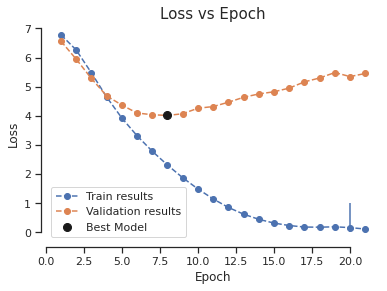

Best Loss-Value for Validation: 4.014110639387248 at Epoch 8


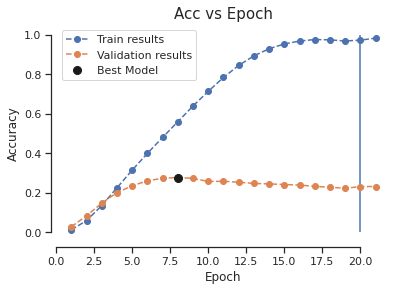

Best Accuracy for Validation: 0.27778 at Epoch 8


In [9]:
min_value = min(val_losses)
min_index = val_losses.index(min_value)+1

plot("Loss vs Epoch", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=(min_index, min_value), extra_pt_label="Best Model")
print(f"Best Loss-Value for Validation: {min_value} at Epoch {min_index}")

max_value = max(val_accs)
max_index = val_accs.index(max_value)+1
plot("Acc vs Epoch", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=(max_index, max_value), extra_pt_label="Best Model")
print(f"Best Accuracy for Validation: {max_value} at Epoch {max_index}")

In [12]:
args.labels = "1%"

In [13]:
# Set Reporting up
#writer_train, writer_val, mkdirpath = report.setReportingUp_trainingSimclr(args)
# Get Data
train_loader, train_loader_nonaug, val_loader = get.data_trainingSimclr(args)
# Get encoder
encoder = get.encoder(args)
args.featureDim, args.numberClasses, epoch_start = encoder.fc.in_features, get.numberClasses(args), 1
# Choose Model
model = sm.modelSIMCLR(encoder, args.featureDim, lf.contrastive_loss_cosine_extra, dim=args.dim, T=args.t)
# Get Optimizer
optimizer = get.optimizer_training(model, args)
# Check Reload
checkpoint = torch.load("saved_models/selfsupervised/imagenet/100ep_256_r18_224_augs/checkpoint_100.tar", map_location=args.device.type)
model = model.cuda()
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_start = checkpoint['epoch']+1
    
criterion = nn.CrossEntropyLoss()

In [14]:
trainedEncoder = model.encoder_f
trainedEncoder.fc = torch.nn.Linear(512,1000)
model = trainedEncoder.cuda()

In [15]:
# Start training
train_losses =[]
val_losses = []
train_accs = []
val_accs = []

"""
for epoch in range(epoch_start, args.epochs + 1):
    train_loss, neg_sim, pos_sim, lr = smtr.train(model, train_loader, optimizer, epoch, args)
    if (epoch % 1) == 0:
        model.module.switch = True
        for _ in range(1):
            train_loss, train_acc = let.train_lr(train_loader_nonaug, model, criterion, optimizer, epoch, args.epochs, args)
            val_loss, val_acc = let.test_lr(val_loader, model, criterion, epoch, args.epochs, args)
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
        model.module.switch = False
"""       
model.switch = True
for epoch in range(50):
    train_loss, train_acc = let.train_lr(train_loader_nonaug, model, criterion, optimizer, epoch, args.epochs, args)
    val_loss, val_acc = let.test_lr(val_loader, model, criterion, epoch, args.epochs, args)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

Train Epoch: [0/20], lr: 0.001000, Loss: 6.9107, Acc_Train: 0.0012: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]
Val Epoch: [0/20], Loss: 6.9077, Acc_Val: 0.0012: 100%|██████████| 196/196 [00:31<00:00,  6.28it/s]
Train Epoch: [1/20], lr: 0.001000, Loss: 6.8952, Acc_Train: 0.0020: 100%|██████████| 51/51 [00:33<00:00,  1.54it/s]
Val Epoch: [1/20], Loss: 6.8935, Acc_Val: 0.0021: 100%|██████████| 196/196 [00:31<00:00,  6.31it/s]
Train Epoch: [2/20], lr: 0.001000, Loss: 6.8702, Acc_Train: 0.0030: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]
Val Epoch: [2/20], Loss: 6.8634, Acc_Val: 0.0039: 100%|██████████| 196/196 [00:31<00:00,  6.27it/s]
Train Epoch: [3/20], lr: 0.001000, Loss: 6.8326, Acc_Train: 0.0071: 100%|██████████| 51/51 [00:33<00:00,  1.54it/s]
Val Epoch: [3/20], Loss: 6.8187, Acc_Val: 0.0074: 100%|██████████| 196/196 [00:31<00:00,  6.25it/s]
Train Epoch: [4/20], lr: 0.001000, Loss: 6.7794, Acc_Train: 0.0141: 100%|██████████| 51/51 [00:32<00:00,  1.55it/s]
Val Epoch: [4/20], L

KeyboardInterrupt: 

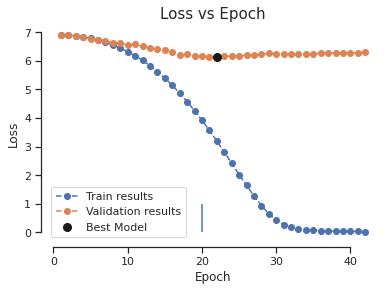

Best Loss-Value for Validation: 6.141093222462401 at Epoch 22


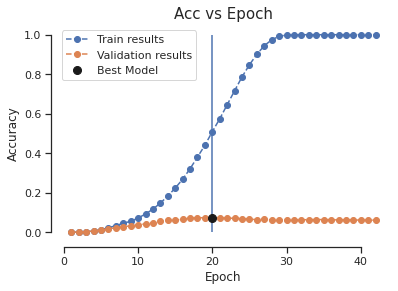

Best Accuracy for Validation: 0.075 at Epoch 20


In [16]:
min_value = min(val_losses)
min_index = val_losses.index(min_value)+1

plot("Loss vs Epoch", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=(min_index, min_value), extra_pt_label="Best Model")
print(f"Best Loss-Value for Validation: {min_value} at Epoch {min_index}")

max_value = max(val_accs)
max_index = val_accs.index(max_value)+1
plot("Acc vs Epoch", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=(max_index, max_value), extra_pt_label="Best Model")
print(f"Best Accuracy for Validation: {max_value} at Epoch {max_index}")

In [4]:
args.labels = "full"
args.dataset_dir = "data/imagenet128"

In [5]:
# Set Reporting up
#writer_train, writer_val, mkdirpath = report.setReportingUp_trainingSimclr(args)
# Get Data
train_loader, train_loader_nonaug, val_loader = get.data_trainingSimclr(args)
# Get encoder
encoder = get.encoder(args)
args.featureDim, args.numberClasses, epoch_start = encoder.fc.in_features, get.numberClasses(args), 1
# Choose Model
model = sm.modelSIMCLR(encoder, args.featureDim, lf.contrastive_loss_cosine_extra, dim=args.dim, T=args.t)
# Get Optimizer
optimizer = get.optimizer_training(model, args)
# Check Reload
checkpoint = torch.load("saved_models/selfsupervised/imagenet/50ep_768/checkpoint_100.tar", map_location=args.device.type)
model = model.cuda()
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_start = checkpoint['epoch']+1
    
criterion = nn.CrossEntropyLoss()

In [6]:
trainedEncoder = model.encoder_f
trainedEncoder.fc = torch.nn.Linear(512,1000)
model = trainedEncoder.cuda()

In [7]:
# Start training
train_losses =[]
val_losses = []
train_accs = []
val_accs = []

"""
for epoch in range(epoch_start, args.epochs + 1):
    train_loss, neg_sim, pos_sim, lr = smtr.train(model, train_loader, optimizer, epoch, args)
    if (epoch % 1) == 0:
        model.module.switch = True
        for _ in range(1):
            train_loss, train_acc = let.train_lr(train_loader_nonaug, model, criterion, optimizer, epoch, args.epochs, args)
            val_loss, val_acc = let.test_lr(val_loader, model, criterion, epoch, args.epochs, args)
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
        model.module.switch = False
"""       
model.switch = True
for epoch in range(50):
    train_loss, train_acc = let.train_lr(train_loader_nonaug, model, criterion, optimizer, epoch, args.epochs, args)
    val_loss, val_acc = let.test_lr(val_loader, model, criterion, epoch, args.epochs, args)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

Train Epoch: [0/20], lr: 0.001000, Loss: 4.6519, Acc_Train: 0.2304: 100%|██████████| 1669/1669 [16:41<00:00,  1.67it/s]
Val Epoch: [0/20], Loss: 3.6094, Acc_Val: 0.3283: 100%|██████████| 66/66 [00:11<00:00,  5.78it/s]
Train Epoch: [1/20], lr: 0.001000, Loss: 2.9435, Acc_Train: 0.4214: 100%|██████████| 1669/1669 [16:43<00:00,  1.66it/s]
Val Epoch: [1/20], Loss: 3.1157, Acc_Val: 0.3872: 100%|██████████| 66/66 [00:11<00:00,  5.92it/s]
Train Epoch: [2/20], lr: 0.001000, Loss: 2.4820, Acc_Train: 0.4883: 100%|██████████| 1669/1669 [16:43<00:00,  1.66it/s]
Val Epoch: [2/20], Loss: 2.9219, Acc_Val: 0.4182: 100%|██████████| 66/66 [00:11<00:00,  5.90it/s]
Train Epoch: [3/20], lr: 0.001000, Loss: 2.1981, Acc_Train: 0.5330: 100%|██████████| 1669/1669 [16:45<00:00,  1.66it/s]
Val Epoch: [3/20], Loss: 2.8395, Acc_Val: 0.4297: 100%|██████████| 66/66 [00:11<00:00,  5.85it/s]
Train Epoch: [4/20], lr: 0.001000, Loss: 1.9773, Acc_Train: 0.5695: 100%|██████████| 1669/1669 [16:45<00:00,  1.66it/s]
Val Epoc

KeyboardInterrupt: 

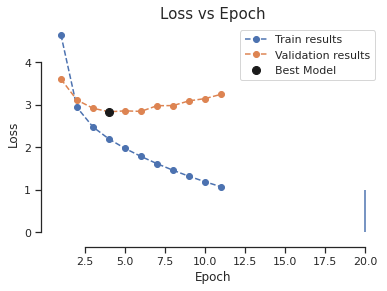

Best Loss-Value for Validation: 2.839496049014005 at Epoch 4


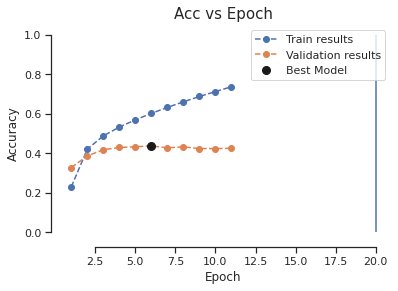

Best Accuracy for Validation: 0.43792 at Epoch 6


In [10]:
min_value = min(val_losses)
min_index = val_losses.index(min_value)+1

plot("Loss vs Epoch", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=(min_index, min_value), extra_pt_label="Best Model")
print(f"Best Loss-Value for Validation: {min_value} at Epoch {min_index}")

max_value = max(val_accs)
max_index = val_accs.index(max_value)+1
plot("Acc vs Epoch", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=(max_index, max_value), extra_pt_label="Best Model")
print(f"Best Accuracy for Validation: {max_value} at Epoch {max_index}")